# DH - Data Science - Grupo 6.

Integrantes:

*    José Roberto Canales Delgado
*    Matías Sala
*    Luciana Sande
*    Bianca Somadossi

# Desafío 2: Construir un Modelo de Regresión.

Objetivo: desarrollar un modelo de regresión que permita predecir el precio por metro cuadrado de una propiedad.

## 1. Entorno de implementación.

### 1.1 Setup inicial.

In [368]:
# initial setup
%run "common/0_notebooks_base_setup.py"

C:\Users\Lu\Lu\Digital House\grupo_6\DH_grupo_6common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
Running command `conda install --yes pandas=1.1.5`... ok
Solving environment: ...working... done

# All requested packages already installed.


bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
Running command `conda install --yes pytest=6.2.1`... ok
Solving environment: ...working... done

# All requested packages already installed.


chardet=4.0.0 already installed
psutil=5.7.2 already installed
Running command `conda install --yes scipy=1.5.2`... ok
Solving environment: ...working... done

# All requested packages already installed.


statsmodels=0.12.1 already installed
Running command `conda install --yes scikit-learn=0.23.2`... ok
Solving environment: ...working... done

# All requested packages already installed.


xlrd=2.0.1 already installed
Running command

<Figure size 432x288 with 0 Axes>

In [369]:
#importamos de todas las librerías que vamos a utilizar

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from lazypredict.Supervised import LazyClassifier, LazyRegressor
import statsmodels.api as sm

%matplotlib inline 


In [370]:
pd.options.display.float_format='{:,.2f}'.format

## 2. Procesamiento de los datos.

### 2.1. Importación del dataset.

In [371]:
#Importaremos el dataset trabajado en el Desafío 1, creando un Dataframe.

data_location = "Data/properati_final.csv"

dataset = pd.read_csv(data_location, sep=",", encoding="UTF-8")


In [372]:
dataset.shape

(44307, 24)

In [373]:
dataset.isna().sum()*100/len(dataset)

property_type              0.00
place_name                 0.05
place_with_parent_names    0.00
state_name                 0.00
lat                        6.36
lon                        6.36
price_aprox_usd            0.00
surface_total_in_m2       20.36
surface_covered_in_m2      0.00
rooms                      0.00
properati_url              0.00
parrilla                   0.00
quincho                    0.00
patio                      0.00
balcon                     0.00
pileta                     0.00
cochera                    0.00
amenities                  0.00
rooms_was_nan              0.00
ciudad                     2.29
barrio                     0.05
subway_distance            0.70
precio_m2                  0.00
segmento_precio_m2         0.00
dtype: float64

<Figure size 720x432 with 0 Axes>

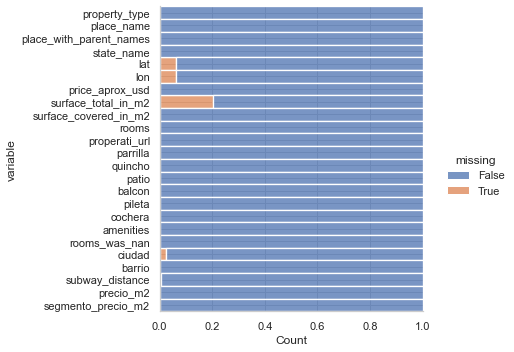

In [374]:
plt.figure(figsize=(10,6))
sns.displot(
    data=dataset.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)

## 3. Eliminación de outliers.

Verificamos los tipos de propiedad que componen el dataset.

In [375]:
data_property_type = dataset["property_type"]

data_property_type_proportions = 100. * data_property_type.value_counts() / len(data_property_type)
data_property_type_proportions

apartment   63.28
house       28.89
PH           5.08
store        2.75
Name: property_type, dtype: float64

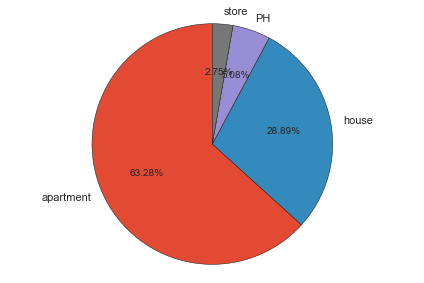

In [376]:
count=dataset["property_type"].value_counts().tolist()
label=dataset["property_type"].value_counts().index

plt.style.use('ggplot')

dic = dict(zip(label,count))

import itertools
newdic={}
for key, group in itertools.groupby(dic, lambda k: 'Others' if (dic[k]<1000) else k):
     newdic[key] = sum([dic[i] for i in list(group)])   

labels = newdic.keys()
sizes = newdic.values()

fig, ax = plt.subplots()

ax.pie(sizes, labels=labels, autopct='%1.2f%%',wedgeprops={"edgecolor":"k"},explode=[0,0,0,0], startangle=90)
ax.axis('equal')
plt.tight_layout()

plt.show()

Relación superficie cubierta en m2 - precio aproximado en USD

Eliminamos las propiedades del tipo Store.

In [377]:
dataset.drop(dataset[(dataset.property_type == 'store')].index, inplace=True)

Text(0.5, 1.0, 'PH')

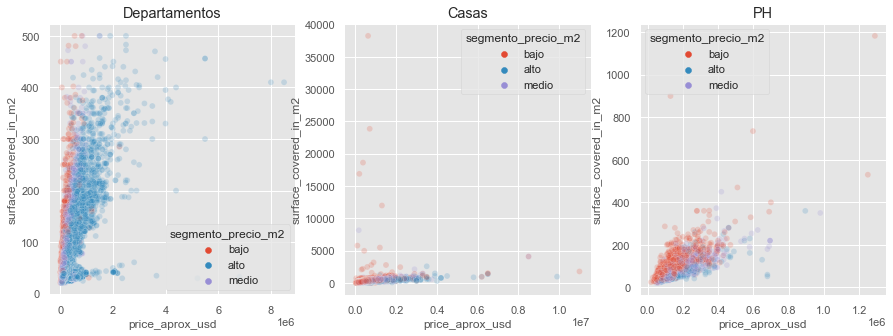

In [378]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.scatterplot(x=((dataset[(dataset.property_type == 'apartment')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'apartment')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[0], hue=dataset['segmento_precio_m2'])


axs[0].set_title("Departamentos")

sns.scatterplot(x=((dataset[(dataset.property_type == 'house')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'house')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[1], hue=dataset['segmento_precio_m2'])


axs[1].set_title("Casas")


sns.scatterplot(x=((dataset[(dataset.property_type == 'PH')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'PH')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[2], hue=dataset['segmento_precio_m2'])


axs[2].set_title("PH")


In [379]:
dataset.drop(dataset[(dataset.surface_covered_in_m2 >500) & (dataset.property_type == 'apartment')].index, inplace=True)

dataset.drop(dataset[(dataset.surface_covered_in_m2 > 1500) & (dataset.property_type == 'house') ].index, inplace=True)

dataset.drop(dataset[(dataset.surface_covered_in_m2 > 300) & (dataset.property_type == 'PH') ].index, inplace=True)


Text(0.5, 1.0, 'PH')

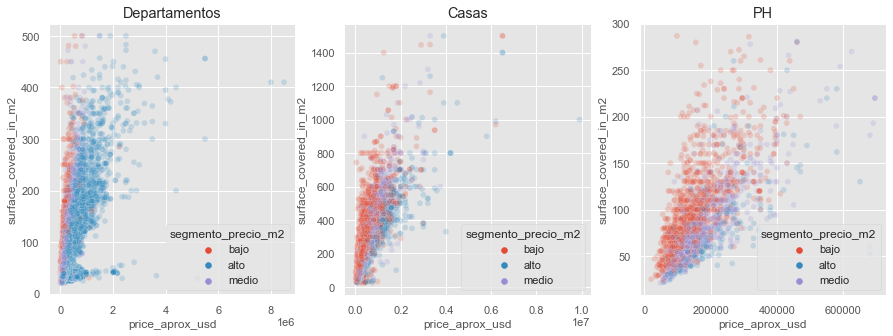

In [380]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.scatterplot(x=((dataset[(dataset.property_type == 'apartment')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'apartment')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[0], hue=dataset['segmento_precio_m2'])


axs[0].set_title("Departamentos")

sns.scatterplot(x=((dataset[(dataset.property_type == 'house')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'house')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[1], hue=dataset['segmento_precio_m2'])


axs[1].set_title("Casas")

sns.scatterplot(x=((dataset[(dataset.property_type == 'PH')].price_aprox_usd)), 
                y=(dataset[(dataset.property_type == 'PH')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[2], hue=dataset['segmento_precio_m2'])


axs[2].set_title("PH")


In [381]:
dataset["price_aprox_usd"].sample(5)

13092     880,000.00
36676     220,000.00
19926     150,000.00
24343   1,450,000.00
27469     174,900.00
Name: price_aprox_usd, dtype: float64

In [382]:
dataset.sort_values('price_aprox_usd',ascending=False,inplace=True)

In [383]:
print(dataset["price_aprox_usd"].head(20))

21591   9,900,000.00
17080   8,500,000.00
17079   8,000,000.00
9713    6,809,000.00
13242   6,500,000.00
14289   6,500,000.00
18448   6,500,000.00
7548    6,500,000.00
22412   6,200,000.00
4259    6,200,000.00
17755   5,800,000.00
20368   5,500,000.00
17077   5,500,000.00
22288   5,500,000.00
9285    5,214,782.00
25524   4,500,000.00
20628   4,400,000.00
8682    4,400,000.00
20350   4,200,000.00
33499   4,200,000.00
Name: price_aprox_usd, dtype: float64


In [384]:
dataset_index_outliers = dataset.loc[(dataset["price_aprox_usd"] <= 8000000)]
# dataset.drop(dataset[(dataset.price_aprox_usd <= 8000000)].index, inplace=True)

Text(0.5, 1.0, 'PH')

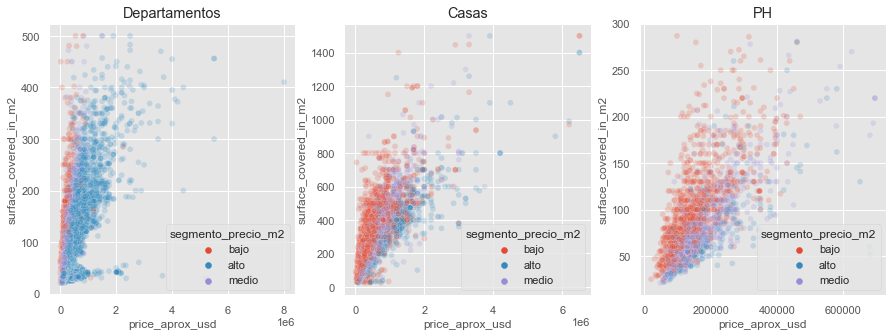

In [385]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.scatterplot(x=((dataset_index_outliers[(dataset_index_outliers.property_type == 'apartment')].price_aprox_usd)), 
                y=(dataset_index_outliers[(dataset_index_outliers.property_type == 'apartment')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[0], hue=dataset_index_outliers['segmento_precio_m2'])


axs[0].set_title("Departamentos")


sns.scatterplot(x=((dataset_index_outliers[(dataset_index_outliers.property_type == 'house')].price_aprox_usd)), 
                y=(dataset_index_outliers[(dataset_index_outliers.property_type == 'house')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[1], hue=dataset_index_outliers['segmento_precio_m2'])


axs[1].set_title("Casas")


sns.scatterplot(x=((dataset_index_outliers[(dataset_index_outliers.property_type == 'PH')].price_aprox_usd)), 
                y=(dataset_index_outliers[(dataset_index_outliers.property_type == 'PH')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[2], hue=dataset_index_outliers['segmento_precio_m2'])


axs[2].set_title("PH")

## 4. Análisis de relaciones

Observamos la correlación de features luego del tratamiento de los datos.

In [386]:
dataset.columns

Index(['property_type', 'place_name', 'place_with_parent_names', 'state_name',
       'lat', 'lon', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'rooms', 'properati_url', 'parrilla',
       'quincho', 'patio', 'balcon', 'pileta', 'cochera', 'amenities',
       'rooms_was_nan', 'ciudad', 'barrio', 'subway_distance', 'precio_m2',
       'segmento_precio_m2'],
      dtype='object')

In [387]:
dataset.sample(3)

,property_type,place_name,place_with_parent_names,state_name,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,...,balcon,pileta,cochera,amenities,rooms_was_nan,ciudad,barrio,subway_distance,precio_m2,segmento_precio_m2
33481,apartment,Puerto Madero,|Argentina|Capital Federal|Puerto Madero|,Capital Federal,-34.61,-58.36,"1,691,550.00",253.00,186.00,5,...,0,0,1,2,0,Puerto Madero,Puerto Madero,0.84,"6,685.97",alto
10727,apartment,Villa Devoto,|Argentina|Capital Federal|Villa Devoto|,Capital Federal,-34.60,-58.52,"459,000.00",215.00,160.00,5,...,1,0,1,3,0,Villa Devoto,Villa Devoto,4.02,"2,134.88",medio
6792,apartment,Nuñez,|Argentina|Capital Federal|Nuñez|,Capital Federal,-34.55,-58.47,"310,000.00",nan,91.00,3,...,1,0,1,3,0,Nuñez,Nuñez,1.11,"2,860.47",alto


(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'surface_total_in_m2'),
  Text(1.5, 0, 'price_aprox_usd'),
  Text(2.5, 0, 'surface_covered_in_m2'),
  Text(3.5, 0, 'rooms'),
  Text(4.5, 0, 'subway_distance')])

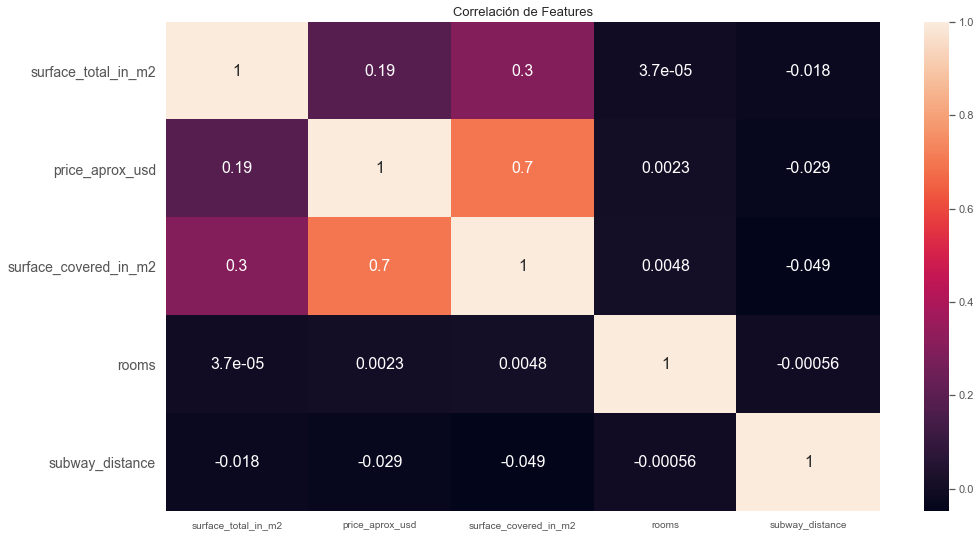

In [388]:
plt.figure(figsize=(16,9))
sns.heatmap(
    dataset[
        ['surface_total_in_m2','price_aprox_usd','surface_covered_in_m2','property_type','rooms','subway_distance']]
    .corr(), annot=True, annot_kws={"size": 16})
plt.title('Correlación de Features', fontsize=13)
plt.yticks(fontsize=14, rotation=0)
plt.xticks(fontsize=10)

In [389]:
# dataset = dataset.drop('surface_total_in_m2', inplace=True)
#inplace=True

## 5. Generación del Modelo

### 5.1 Definición de las columnas a utilizar

Elegimos las columnas que son significativas para la predicción:

* surface_covered_in_m2
* place_with_parent_names
* price_aprox_usd
* property_type
* rooms
* subway_distance


### 5.2 LazyPredict

*https://www.themachinelearners.com/lazypredict/*

¿Qué es? Una librería de Python que nos ayudara saber qué modelos son los mejores para los datos con los que estamos trabajando.
LazyPredict nos permite, con una línea, lanzar una barbaridad de modelos de regresión de scikit-Learn (38) con los parámetros por defecto para ver el rendimiento de cada uno de ellos. 
Esto nos da la ventaja de ver el rendimiento de cada uno de ellos para nuestros datos y poder enfocar en optimizar aquellos que mejor funcionan para nuestros datos.

In [390]:
capital_dataset = pd.read_csv("Data/capital_federal_data.csv", sep=",", encoding="UTF-8")
zona_norte_dataset = pd.read_csv("Data/zona_norte_data.csv", sep=",", encoding="UTF-8")

Separo el dataset en features dependientes e independientes

In [391]:
X_c = capital_dataset[['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','subway_distance']]
y_c = capital_dataset.price_aprox_usd

X_zn = zona_norte_dataset[['surface_covered_in_m2', 'lat', 'lon', 'precio_m2']]
y_zn = zona_norte_dataset.price_aprox_usd

Divido el dataset en entrenamiento y prueba

In [400]:
X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y_c, random_state= 7)
X_zn_train, X_zn_test, y_zn_train, y_zn_test = train_test_split(X_zn, y_zn, random_state= 7)

Creo un objeto de la clase LazyRegressor

In [401]:
rg = LazyRegressor(verbose=0,ignore_warnings=False,  custom_metric=None)

Ajustamos nuestros datos de entrenamiento y prueba al objeto LazyClassifier

In [394]:
models,predictions_c = rg.fit(X_c_train, X_c_test, y_c_train, y_c_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [03:17<00:00,  4.70s/it]


Como métricas para regresión están el R cuadrado y el RMSE por defecto, pero podemos elegir la métrica que queramos con el atributo custom_metric

In [395]:
predictions_c

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.91,0.91,"105,293.34",2.97
RandomForestRegressor,0.90,0.90,"111,834.98",5.23
BaggingRegressor,0.90,0.90,"111,846.77",0.63
GradientBoostingRegressor,0.89,0.89,"117,331.28",1.80
XGBRegressor,0.85,0.85,"133,012.04",0.47
LGBMRegressor,0.85,0.85,"133,329.25",0.14
KNeighborsRegressor,0.82,0.82,"146,842.33",0.12
HistGradientBoostingRegressor,0.80,0.80,"157,092.46",0.49
DecisionTreeRegressor,0.79,0.79,"159,735.47",0.10


Visualizamos los resultados de las métricas de cada modelo.

[(0.0, 1.0)]

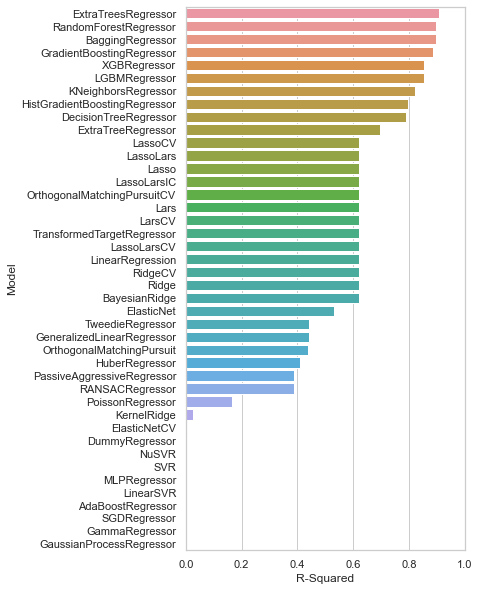

In [396]:
predictions_c["R-Squared"] = [0 if i < 0 else i for i in predictions_c.iloc[:,0] ]
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_c.index, x="R-Squared", data=predictions_c)
ax.set(xlim=(0, 1))

In [402]:
models,predictions_zn = rg.fit(X_zn_train, X_zn_test, y_zn_train, y_zn_test)

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [01:38<00:00,  2.36s/it]


In [404]:
predictions_zn

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
ExtraTreesRegressor,0.83,0.83,"143,608.74",2.05
LGBMRegressor,0.82,0.82,"144,287.48",0.13
XGBRegressor,0.82,0.82,"146,426.40",0.35
RandomForestRegressor,0.82,0.82,"146,590.20",3.28
HistGradientBoostingRegressor,0.81,0.81,"149,346.09",0.54
GradientBoostingRegressor,0.81,0.81,"150,906.20",0.94
KNeighborsRegressor,0.79,0.79,"155,695.77",0.07
BaggingRegressor,0.79,0.79,"158,091.58",0.35
DecisionTreeRegressor,0.61,0.61,"213,704.67",0.07


[(0.0, 1.0)]

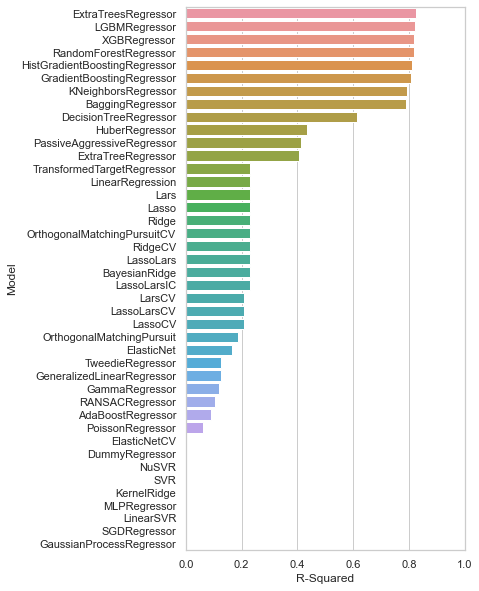

In [405]:
predictions_zn["R-Squared"] = [0 if i < 0 else i for i in predictions_zn.iloc[:,0] ]
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions_zn.index, x="R-Squared", data=predictions_zn)
ax.set(xlim=(0, 1))

## 6. Regresión Lineal Simple

In [406]:
# defino una fx que calcule la Raiz del Error cuadrático medio (RMSE) y r2, imprima sus resultados y los devuelva.

def error(ground_truth, prediction):

    r2 = r2_score(ground_truth, prediction)
    RMSE = mean_squared_error(ground_truth, prediction, squared= False)

    print('R2:' ,r2)
    print ('RMSE:' , round(RMSE))

    return r2, RMSE

Calculo los precios promedio del dataset total y de los data ser separados por zona (Capital Federal y Zona Norte Pcia. Bs. As.)

In [407]:
#Precio Promedio total
total_price_mean = dataset.price_aprox_usd.mean()
total_price_mean

295653.24982576777

In [408]:
#Precio promedio Capital Federal
c_price_mean = capital_dataset.price_aprox_usd.mean()
c_price_mean

272721.4149320703

In [409]:
#Precio promedio Zona Norte Pcia. Bs. As.
zn_price_mean = zona_norte_dataset.price_aprox_usd.mean()
zn_price_mean

342429.6263958889

Creo series con cada precio promedio.

In [410]:
total_price_mean = pd.Series([total_price_mean])
c_price_mean = pd.Series([c_price_mean])
zn_price_mean = pd.Series([zn_price_mean])

In [411]:
total_price_mean = total_price_mean.repeat(len(dataset.price_aprox_usd))
total_price_mean

0   295,653.25
0   295,653.25
0   295,653.25
0   295,653.25
0   295,653.25
       ...    
0   295,653.25
0   295,653.25
0   295,653.25
0   295,653.25
0   295,653.25
Length: 43046, dtype: float64

In [412]:
c_price_mean = c_price_mean.repeat(len(capital_dataset.price_aprox_usd))
c_price_mean

0   272,721.41
0   272,721.41
0   272,721.41
0   272,721.41
0   272,721.41
       ...    
0   272,721.41
0   272,721.41
0   272,721.41
0   272,721.41
0   272,721.41
Length: 24069, dtype: float64

In [413]:
zn_price_mean = zn_price_mean.repeat(len(zona_norte_dataset.price_aprox_usd))
zn_price_mean

0   342,429.63
0   342,429.63
0   342,429.63
0   342,429.63
0   342,429.63
       ...    
0   342,429.63
0   342,429.63
0   342,429.63
0   342,429.63
0   342,429.63
Length: 20238, dtype: float64

Calculo el r2 y el RMSE con la función que definimos al principio.

In [414]:
total_r2_mean, total_RMSE_mean = error(total_price_mean, dataset.price_aprox_usd)
c_r2_mean, c_RMSE_mean = error(c_price_mean, capital_dataset.price_aprox_usd)
zn_r2_mean, zn_RMSE_mean = error(zn_price_mean, zona_norte_dataset.price_aprox_usd)

R2: 0.0
RMSE: 334111
R2: 0.0
RMSE: 362941
R2: 0.0
RMSE: 375660


Defino una función para calcular un modelo de regresión lineal simple.

In [415]:
def reg_lineal_simple(data, feature):

    X = data[[feature]] #training data
    y = data.price_aprox_usd #target values

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 7) #separamos en entrenamiento y prueba

    lm = linear_model.LinearRegression()
    model = lm.fit(X, y) #creamos una instancia de la clase LinearRegression y fiteamos o ajustamos el modelo

    predictions = lm.predict(X_test) #predecimos usando el modelo lineal

    cv = cross_validate(estimator=linear_model.LinearRegression(), X=X_train, y=y_train, scoring = ['neg_root_mean_squared_error', 'r2'], cv=3)

    sns.scatterplot(data=data, x=feature, y="price_aprox_usd", hue= 'segmento_precio_m2')
    plt.plot(X_train, model.predict(X_train), color='red', linewidth=2)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    return cv

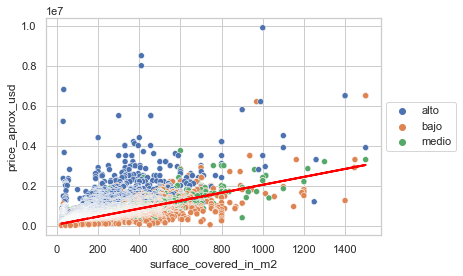

In [416]:
cv_total = reg_lineal_simple(dataset, 'surface_covered_in_m2')

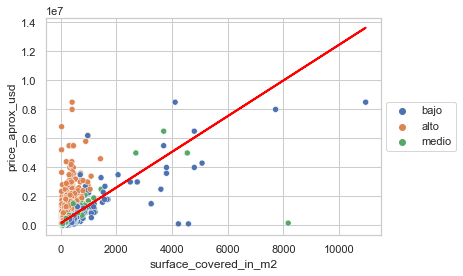

In [417]:
cv_capital = reg_lineal_simple(capital_dataset, 'surface_covered_in_m2')

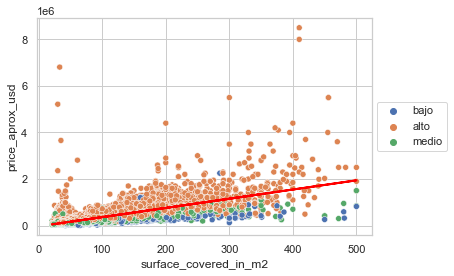

In [418]:
c_depto = capital_dataset[capital_dataset.property_type == 'apartment']
cv_c_depto = reg_lineal_simple(c_depto, 'surface_covered_in_m2')

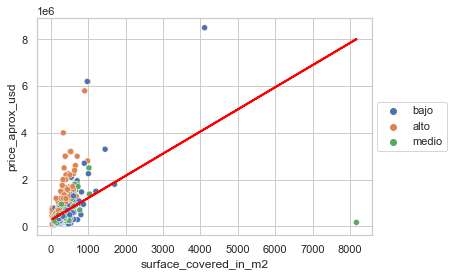

In [419]:
c_casa = capital_dataset[capital_dataset.property_type == 'house']
cv_c_casa = reg_lineal_simple(c_casa, 'surface_covered_in_m2')

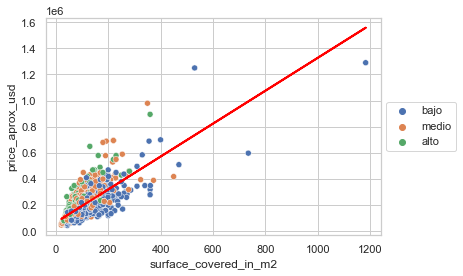

In [420]:
c_ph = capital_dataset[capital_dataset.property_type == 'PH']
cv_c_ph = reg_lineal_simple(c_ph, 'surface_covered_in_m2')

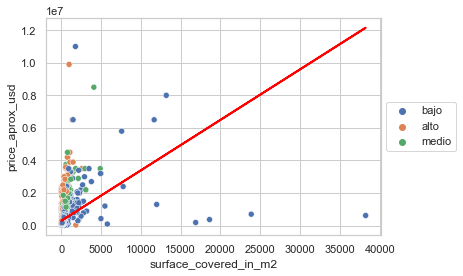

In [421]:
cv_zn = reg_lineal_simple(zona_norte_dataset, 'surface_covered_in_m2')

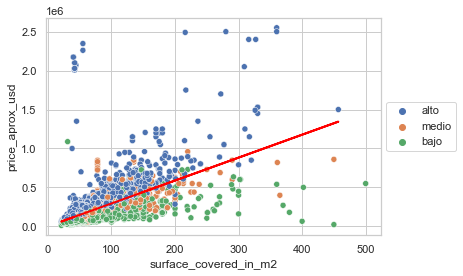

In [422]:
zn_depto = zona_norte_dataset[zona_norte_dataset.property_type == 'apartment']
cv_zn_depto = reg_lineal_simple(zn_depto, 'surface_covered_in_m2')

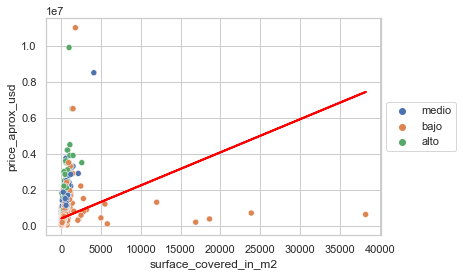

In [423]:
zn_casa = zona_norte_dataset[zona_norte_dataset.property_type == 'house']
cv_zn_casa = reg_lineal_simple(zn_casa, 'surface_covered_in_m2')

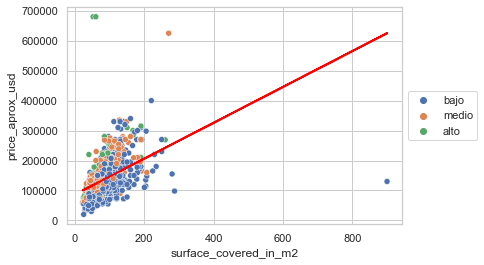

In [424]:
zn_ph = zona_norte_dataset[zona_norte_dataset.property_type == 'PH']
cv_zn_ph = reg_lineal_simple(zn_ph, 'surface_covered_in_m2')

Creamos un diccionario con todos los RMSE que calculamos.

In [425]:
rmse_dict = {
    'RMSE_total' : cv_total['test_neg_root_mean_squared_error'],
    'RMSE_capital' : cv_capital['test_neg_root_mean_squared_error'],
    'RMSE_zn':cv_zn['test_neg_root_mean_squared_error'],
    'RMSE_prom_t': total_RMSE_mean,
    'RMSE_prom_c' : c_RMSE_mean,
    'RMSE_prom_zn' : zn_RMSE_mean
    }

In [426]:
total_plot = pd.DataFrame(rmse_dict)

In [427]:
total_plot[['RMSE_total', 'RMSE_capital','RMSE_zn', 'RMSE_prom_t', 'RMSE_prom_c','RMSE_prom_zn']] = total_plot[['RMSE_total', 'RMSE_capital','RMSE_zn', 'RMSE_prom_t', 'RMSE_prom_c','RMSE_prom_zn']] * -1


<AxesSubplot:>

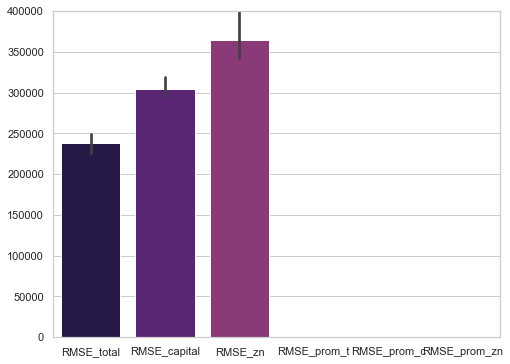

In [428]:
plt.figure(figsize=(8, 6))
plt.ylim(0, 400000)
sns.barplot(data=total_plot, palette= 'magma')

In [429]:
rmse_dict_c = {
    'RMSE_capital' : cv_capital['test_neg_root_mean_squared_error'],
    'RMSE_c_depto' : cv_c_depto['test_neg_root_mean_squared_error'],
    'RMSE_c_casa':cv_c_casa['test_neg_root_mean_squared_error'],
    'RMSE_c_ph':cv_c_ph['test_neg_root_mean_squared_error'],
    'RMSE_promedio_c' : c_RMSE_mean
    }

In [430]:
c_RMSE_mean

362941.1766690629

In [431]:
c_plot = pd.DataFrame(rmse_dict_c)

In [432]:
c_plot[['RMSE_capital','RMSE_c_depto', 'RMSE_c_casa', 'RMSE_c_ph','RMSE_promedio_c']] = c_plot[['RMSE_capital','RMSE_c_depto', 'RMSE_c_casa', 'RMSE_c_ph','RMSE_promedio_c']] * -1


<AxesSubplot:>

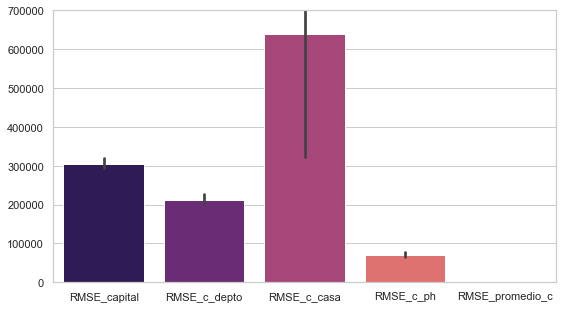

In [433]:
plt.figure(figsize=(9, 5))
plt.ylim(0, 700000)
sns.barplot(data=c_plot, palette= 'magma')

In [434]:
total_plot.to_csv('./data/RMSE_lineal_simple_total.csv', index=False)
c_plot.to_csv('./data/RMSE_lineal_simple_capital.csv', index=False)
# zn_plot.to_csv('./data/RMSE_lineal_simple_zn.csv', index=False)

## 7. Regresión Lineal Múltiple

Defino una función para calcular un modelo de regresión lineal múltiple.

In [ ]:
def reg_lineal_multiple(data, features):

    X = data[features]
    y = data.price_aprox_usd

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 7)

    X = sm.add_constant(X_train)

    lm = sm.OLS(y_train, X_train).fit() 
    

    cv = cross_validate(estimator=linear_model.LinearRegression(), X=X_train, y=y_train, scoring=['neg_root_mean_squared_error', 'r2'], cv=3)


    return cv, lm

In [ ]:
cv_tot, lm_tot = reg_lineal_multiple(df,['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','distance_obelisco'] )


In [ ]:
lm_tot.summary()        


In [ ]:
cv_tot


In [ ]:
X = df[['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','distance_obelisco']]
y = df.price_aprox_usd
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

In [ ]:
#errores en test
predictions = lm_tot.predict(X_test)

error(y_test, predictions)

In [ ]:
#errores en train
predictions = lm_tot.predict(X_train)

error(y_train, predictions)

### Capital

In [ ]:
cv_depto, lm_depto = reg_lineal_multiple(df_depto,['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','distance_obelisco'] )
lm_depto.summary()

In [ ]:
cv_depto

### Zona Norte

In [ ]:
df_casa= pd.read_csv('./data/df_casa.csv')


In [ ]:
cv_casa, lm_casa = reg_lineal_multiple(df_casa,['surface_covered_in_m2', 'lat', 'lon', 'precio_m2','distance_obelisco'] )
lm_casa.summary()

In [ ]:
cv_casa


In [ ]:
rmse_dict = {'RMSE_ph' : cv_ph['test_neg_root_mean_squared_error'] , 'RMSE_casa':cv_casa['test_neg_root_mean_squared_error'], 'RMSE_depto':cv_depto['test_neg_root_mean_squared_error'], 'RMSE_store':cv_store['test_neg_root_mean_squared_error'], 'RMSE':cv_tot['test_neg_root_mean_squared_error']}


In [ ]:
df_plot = pd.DataFrame(rmse_dict)


In [ ]:
df_plot[['RMSE', 'RMSE_store','RMSE_casa', 'RMSE_depto', 'RMSE_ph']] = df_plot[['RMSE', 'RMSE_store','RMSE_casa', 'RMSE_depto', 'RMSE_ph']] * -1


In [ ]:
df_plot['model'] = 'multivariable'


In [ ]:
plt.figure(figsize=(8, 6))
plt.ylim(0, 300000)
sns.barplot(data=df_plot, palette= 'magma')

In [ ]:
df_RMSE_lineal = pd.read_csv('./data/RMSE_lineal_simple.csv')


In [ ]:
df_RMSE_lineal['model'] ='lineal'


In [ ]:
df_plot = pd.concat([df_RMSE_lineal,df_plot])


In [ ]:
df_plot = pd.melt(df_plot, id_vars=['model'])


In [ ]:
df_plot.sample(2)


In [ ]:
plt.figure(figsize=(8, 6))
plt.ylim(0, 250000)
sns.barplot(data= df_plot, x ='variable', y= 'value', hue= 'model', palette= 'magma')

In [ ]:
Regularización


In [ ]:
L2 = Regularización con Ridge


In [ ]:
# Regularización con Ridge

from sklearn.preprocessing import StandardScaler

X = df[['lat', 'lon', 'surface_covered_in_m2', 'distance_obelisco', 'precio_m2']]

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

y = df['price_aprox_usd']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size = 0.3, random_state = 117)

model_ridge_cv = linear_model.RidgeCV(alphas= [0.3, 0.5, 1.0, 1.1, 1.15, 1.17, 1.18, 1.19, 1.2, 1.21, 1.22, 1.3, 1.4, 1.5, 10.0, 20, 50, 100], 
                                   fit_intercept=True, scoring='neg_root_mean_squared_error', normalize=False, cv=10)

model_fit_ridge_cv = model_ridge_cv.fit(X_train, y_train)

print('El mejor valor de  𝜆  es:')
print(model_fit_ridge_cv.alpha_)
print('El valor de  𝑅MSE  en train es:')
print(model_fit_ridge_cv.best_score_)

In [ ]:
best_alpha = model_fit_ridge_cv.alpha_
model_ridge = linear_model.Ridge(alpha = best_alpha, fit_intercept = True, normalize = False)
model_fit_ridge = model_ridge.fit(X_train, y_train)
print(model_fit_ridge.coef_)
print(model_fit_ridge.intercept_)
print(model_fit_ridge.score(X_train, y_train))

In [ ]:
pred= model_fit_ridge.predict(X_test)

In [ ]:
r2, RMSE_ridge = error(y_test, pred )


In [ ]:
df_plot = df_plot.append({'model': 'Ridge' ,'variable': 'RMSE',	'value' : RMSE_ridge}, ignore_index=True)


In [ ]:
df_plot

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x = 'model', y= 'value', data= df_plot[df_plot.variable == 'RMSE'], palette='magma')

In [ ]:
Lasso

In [ ]:
X_train

In [ ]:
alphas = np.logspace(-2,7,20)

error_test_lista = []
error_train_lista = []

params = pd.DataFrame()

for alpha in alphas:
#     print(alpha, end = ', ')
    lasso = linear_model.Lasso(alpha = alpha)
    lasso.fit(X_train, y_train)
    params = pd.concat([params,pd.DataFrame({f'{alpha}':lasso.coef_})], axis = 1)
    
    error_train = mean_squared_error(y_train, lasso.predict(X_train), squared=False)
    error_test  = mean_squared_error(y_test,  lasso.predict(X_test), squared=False)
    
    error_test_lista.append( error_test )
    error_train_lista.append(error_train)

In [ ]:
alphas

In [ ]:
plt.plot(alphas[::-1], error_test_lista, label = 'test')
plt.plot(alphas[::-1], error_train_lista, label = 'train')


plt.title('Como evolucionan las métricas a medida que regularizo')
plt.legend()
plt.xlabel('1 / lambda')
plt.ylabel('error')
plt.xscale('log')
plt.show()

In [ ]:
error_test_lista

In [ ]:
params

In [ ]:
df_plot = df_plot.append({'model': 'Lasso' ,'variable': 'RMSE',	'value' : error_test_lista[0]}, ignore_index=True)


In [ ]:
params_to_plot = params
alphas_to_plot = params_to_plot.columns
alphas_to_plot = np.array(alphas_to_plot, dtype = 'float')

In [ ]:
plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[0].values), label = 'lat')
plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[1].values), label = 'lon')
plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[2].values), label = 'surface')
plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[3].values), label = 'distancia ob')
plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[4].values), label = 'precio m2')
# plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[5].values), label = 'b5')
# plt.plot(alphas_to_plot, np.abs(params_to_plot.loc[6].values), label = 'b6')

plt.legend()
plt.xticks(rotation = 90)
plt.xscale('log')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x = 'model', y= 'value', data= df_plot[df_plot.variable == 'RMSE'], palette='magma')

In [ ]:
XGBoost


In [ ]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [ ]:
X= df[['surface_covered_in_m2', 'lat', 'lon', 'precio_m2', 'distance_obelisco',  'property_type']]
X_encoded = pd.get_dummies(X, columns=['property_type'], sparse=True)
y = df.price_aprox_usd
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=7)

In [ ]:
X_train.sample(2)


In [ ]:
 xgb.XGBRegressor( learning_rate=0.5, max_depth=6, reg_lambda=5)
rg_xgb.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_set=[(X_test,y_test)])

In [ ]:
pred = rg_xgb.predict(X_test)


In [ ]:
from sklearn.model_selection import GridSearchCV


In [ ]:
param_grid = {
    'max_depth': [6, 7],
    'learning_rate': [0.7,0.5,0.3],
    'reg_lambda':[5,7,8]}

In [ ]:
optimal_params= GridSearchCV(
    estimator=xgb.XGBRegressor(),
    param_grid=param_grid,
    scoring= 'neg_root_mean_squared_error',
    verbose=2,
    n_jobs=10,
    cv=3)

In [ ]:
optimal_params.fit(X_train, y_train)

In [ ]:
print(optimal_params.best_score_)
print(optimal_params.best_params_)

In [ ]:
rg_xgb.feature_importances_.sum()


In [ ]:
plt.figure(figsize=(8, 6))
plt.bar( ['surface', 'lat', 'lon', 'precio_m2','obelisco', 'depto', 'casa', 'ph', 'store'],rg_xgb.feature_importances_[0:9], color= 'indigo')

In [ ]:
df_plot = df_plot.append({'model': 'XGBoost' ,'variable': 'RMSE',	'value' : (-optimal_params.best_score_)}, ignore_index=True)


In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x = 'model', y= 'value', data= df_plot[df_plot.variable == 'RMSE'], palette='magma')